In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import seaborn as sb
import deepdish as dd

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'dl4tsc_inc'
nb_classes = 2
# clean = True

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/pyt

### data collecting

In [2]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [3]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [4]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [5]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    13610
0     8244
dtype: int64

val: 
1    4568
0    2717
dtype: int64

test: 
1    12337
0     3139
dtype: int64


### training

In [6]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting,model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_acc')

In [7]:
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes)
model = modelconf.config
print("Last 5 layers:")
for i in model.layers[-5:]:
    print(i.name)

############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Last 5 layers:
batch_normalization_17
activation_18
global_average_pooling1d_1
dense_1
activation_19


In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(nb_classes)}
print(class_weights)

{0: 1.3254488112566716, 1: 0.8028655400440853}


In [10]:
h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                     preprocessing_train_stats=''),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                         preprocessing_train_stats=''),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list,
             class_weight=class_weights)

Epoch 1/100
682/683 [============================>.] - ETA: 0s - loss: 0.3748 - acc: 0.8355
Epoch 00001: val_acc improved from -inf to 0.43157, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_dl4tsc_inc_custom.h5
683/683 [==============================] - 205s 300ms/step - loss: 0.3745 - acc: 0.8357 - val_loss: 1.5274 - val_acc: 0.4316
Epoch 2/100
682/683 [============================>.] - ETA: 0s - loss: 0.2074 - acc: 0.9234
Epoch 00002: val_acc improved from 0.43157 to 0.46328, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_dl4tsc_inc_custom.h5
683/683 [==============================] - 194s 284ms/step - loss: 0.2073 - acc: 0.9234 - val_loss: 2.6175 - val_acc: 0.4633
Epoch 3/100
682/683 [============================>.] - ETA: 0s - loss: 0.1676 - acc: 0.9396
Epoch 00003: val_acc improved from 0.46328 to 0.72011, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_dl4tsc_inc_cust

In [11]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                  preprocessing_train_stats=''),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [12]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(pred, axis=1))

0.827838738074727

Text(33.0, 0.5, 'actual')

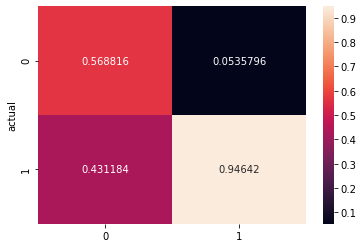

In [47]:
import seaborn as sns

cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel('actual')

#### 0=melanogaster, 1=suzukii, 2=zaprionus

In [41]:
cm.sum(axis=0)

array([ 4483, 10993])

In [38]:
mat = np.random.randn(2,3)
np.sum(mat, axis=0)

array([-0.04146399, -2.43996216,  0.93576026])

In [36]:
mat

array([[ 0.2088636 , -1.95967012, -1.32818605],
       [ 0.19686124,  0.73846658,  0.17136828]])

In [14]:
pd.Series(y_test).value_counts()

1    12337
0     3139
dtype: int64

In [15]:
y_pred = np.argmax(pred, axis=1)

sub = pd.concat([pd.Series(y_test), pd.Series(X_test)], axis=1)
sub['preds'] = y_pred
sub.columns = ['labels','fnames','preds']
sub['datestr'] = get_wingbeat_dates(sub.fnames)[2]

In [16]:
sub.to_csv(f'{TEMP_DATADIR}/df_{model_setting}_{data_setting}_{splitting}.csv', index=False)